# 2D Isostatic gravity inversion - Inverse Problem

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
matplotlib.use('TkAgg', force=True)
import matplotlib.pyplot as plt
import math
import cPickle as pickle
import datetime
import matplotlib.gridspec as gridspec
#from IPython.display import Image as img
#from IPython.display import Markdown as md
#from IPython.display import display as dp
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Model parameters

In [3]:
# Model`s limits
ymin = 0.0
ymax = 195000.0
zmin = -1000.0
zmax = 37400.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

## Prisms coordenates.

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

## Observation coordinates.

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds = np.array([2550.0])
dcc = np.array([2670.0])
doc = np.array([2840.0])
dm = np.array([3200.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 117000.0

# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc
# defining sediments layers density vector
ds = np.reshape(np.repeat(ds,n),(n,1))

# S0 => isostatic compensation surface (Airy's model)
S0 = np.array([26500.0])

## Surface water

In [8]:
tw = np.reshape(np.loadtxt('../data/model_simple_bathymetry.txt'),(n,1))

## True model

In [9]:
true_basement = np.reshape(np.loadtxt('../data/model_simple_I_true_basement_surface.txt'),(n,1))

In [10]:
true_moho = np.reshape(np.loadtxt('../data/model_simple_I_true_moho_surface.txt'),(n,1))

In [11]:
# True reference moho surface (SR = S0+dS0)
true_dS0 = np.array([500.0])

In [12]:
# True layer sediments thickness
true_ts = true_basement - tw

In [13]:
# True layer mantle thickness
true_tm = S0 - true_moho

In [14]:
# true parameters vector
ptrue = np.vstack((true_ts, true_tm, true_dS0))

In [15]:
# synthetic data
gsyn = np.reshape(np.loadtxt('../data/model_simple_I_simulated_gravity_data.txt'),(n,1))

## Known depths

In [16]:
# Known values: basement and moho surfaces

base_known = np.loadtxt('../data/model_simple_I_base_known_depths.txt')

moho_known = np.loadtxt('../data/model_simple_I_moho_known_depths.txt')

## Interpretive model

In [17]:
# initial guess basement surface
ini_basement = np.reshape(np.loadtxt('../data/model_simple_initial_basement_surface.txt'),(n,1))

# initial guess moho surface
ini_moho = np.reshape(np.loadtxt('../data/model_simple_initial_moho_surface.txt'),(n,1))

# initial guess data
g0 = np.reshape(np.loadtxt('../data/model_simple_I_initial_guess_gravity_data.txt'),(n,1))

## Inversion model

In [18]:
g = np.reshape(np.loadtxt('../data/model_simple_I_predicted_gravity_data_0_-7_-6_-6_syn_data.txt'),(n,1))
p = np.reshape(np.loadtxt('../data/model_simple_I_parameter_vector_0_-7_-6_-6_syn_data.txt'),(2*n+1,1))
ts = p[0:n]
tm = p[n:n+n]

In [19]:
# Inverrsion results
RM = S0 + p[n+n]
basement = tw + p[0:n]
moho = S0 - p[n:n+n]

## Lithostatic Stress

In [20]:
sgm_true = 9.81*(10**(-6))*(dw*tw + ds*true_ts + dc*(S0-tw-true_ts-true_tm)+dm*true_tm)

sgm = 9.81*(10**(-6))*(dw*tw + ds*ts + dc*(S0-tw-ts-tm)+dm*tm)

## Inversion model plot

In [21]:
polygons_water = []
for (yi, twi) in zip(yc, tw):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments = []
for (yi, twi, si, dsi) in zip(yc, np.reshape(tw,(n,)), np.reshape(basement,(n,)), ds):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, si, si]]).T,
                                                    props={'density': ds - dcc}))

polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, 35000., 35000.]]).T,
                                                    props={'density': dm - dcc}))

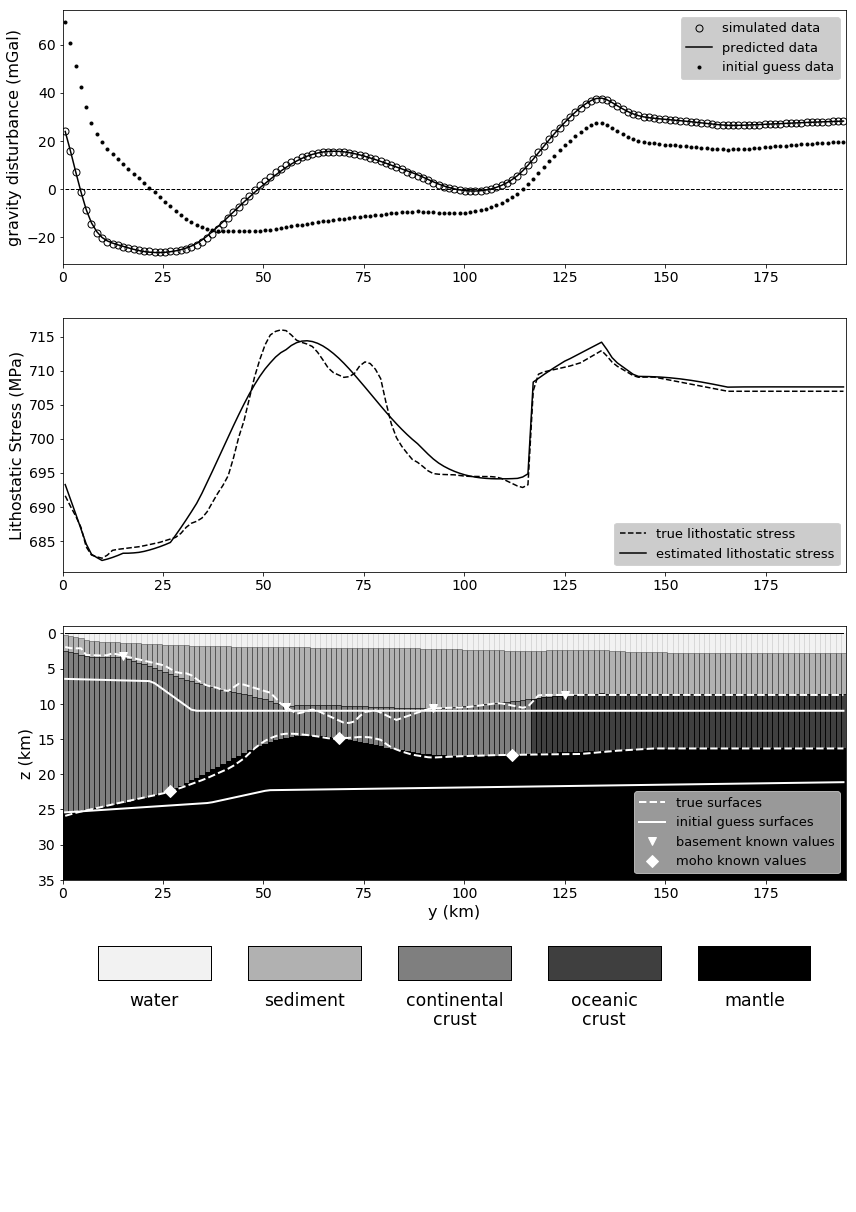

In [22]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,17))
#alfa = 3.33*(17)/(12)
#fig = plt.figure(figsize=(3.33,alfa), dpi=600)

plt.subplot(4,1,1)
zeros = np.zeros_like(yc)
plt.plot(0.001*yc, zeros, '--k', linewidth=1)
plt.plot(0.001*yc, gsyn, 'ok', mfc='none', markersize=7, label='simulated data')
plt.plot(0.001*yc, g, '-k', label='predicted data')
plt.plot(0.001*yc, g0, '.k', label='initial guess data')
plt.xlim(0.001*ymin, 0.001*ymax)
plt.ylabel('gravity disturbance (mGal)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.tight_layout()
plt.legend(loc='best', fontsize=13, facecolor='silver')

plt.subplot(4,1,2)
plt.plot(0.001*yc, sgm_true, '--k', label='true lithostatic stress')
plt.plot(0.001*yc, sgm, '-k', label='estimated lithostatic stress')
plt.xlim(0.001*ymin, 0.001*ymax)
plt.ylabel('Lithostatic Stress (MPa)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.tight_layout()
plt.legend(loc='best', fontsize=13, facecolor='silver')        

plt.subplot(4,1,3)
plt.plot(yc, zeros, '-k', linewidth=1)
#mpl.paths([[ymin, 0.0]], [[ymax, 0.0]], style='-k', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    mpl.polygon(pwi, style='None', linewidth=0, fill='black', alpha=0.05)
for (ps0i) in (polygons_sediments):
    mpl.polygon(ps0i, style='None', linewidth=0, fill='black', alpha=0.3)
for (pci) in (polygons_crust[:len(yc[aux])]):
    mpl.polygon(pci, style='None', linewidth=0, fill='black', alpha=0.5)
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    mpl.polygon(pcoi, style='None', linewidth=0, fill='black', alpha=0.75)
for (pmi) in (polygons_mantle):
    mpl.polygon(pmi, style='None', linewidth=0, fill='black')

plt.plot(yc, true_basement, '--w', linewidth=2, label='true surfaces')
plt.plot(yc, true_moho, '--w', linewidth=2)#, label='true moho surface')
plt.plot(yc, ini_basement, '-w', linewidth=2, label='initial guess surfaces')
plt.plot(yc, ini_moho, '-w', linewidth=2)#, label='initial moho surface')
plt.plot(base_known[:,0], base_known[:,1], 'vw', markersize=8.5, label='basement known values')
plt.plot(moho_known[:,0], moho_known[:,1], 'Dw', markersize=8.5, label='moho known values')
plt.ylim(35000., zmin)
plt.xlim(ymin, ymax)
plt.xlabel('y (km)', fontsize=16)
plt.ylabel('z (km)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
mpl.m2km()
#plt.tight_layout()
plt.legend(loc='lower right', fontsize=13, facecolor='silver')

plt.subplot(4,1,4)#, frame_on=False)
X, Y = fig.get_dpi()*fig.get_size_inches()
plt.axis('off')

layers_list1 = ['water', 'sediment', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', 'crust', 'crust', '']
alpha_list = [0.05, 0.3, 0.5, 0.75, 1.0]
ncols = len(alpha_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for alpha, layers1, layers2 in zip(alpha_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line1 = Y - Y*0.15
    yf_line2 = Y - Y*0.30
    yf_line3 = Y - Y*0.45
    yf_line4 = Y - Y*0.60
    yf_line5 = Y - Y*0.75
    yf_line6 = Y - Y*0.90
    yf_line7 = Y - Y*1.0
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.28
    
    plt.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.12), horizontalalignment='center', verticalalignment='top')
    plt.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.12), horizontalalignment='center', verticalalignment='top')
    i-=1
    poly1 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line1, yf_line1]]).T)
    poly2 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line1, yf_line1, yf_line2, yf_line2]]).T)
    poly3 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line2, yf_line2, yf_line3, yf_line3]]).T)
    poly4 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line3, yf_line3, yf_line4, yf_line4]]).T)
    poly5 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line4, yf_line4, yf_line5, yf_line5]]).T)
    poly6 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line5, yf_line5, yf_line6, yf_line6]]).T)
    poly7 = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yf_line6, yf_line6, yf_line7, yf_line7]]).T)
    mpl.polygon(poly1, style='None', linewidth=1, fill='black', alpha=alpha)
    mpl.polygon(poly2, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly3, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly4, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly5, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly6, style='None', linewidth=0, fill='white', alpha=alpha)
    mpl.polygon(poly7, style='None', linewidth=0, fill='white', alpha=alpha)
    
plt.tight_layout()

#mpl.savefig('../manuscript/figures/model-simple_I.png', dpi='figure')
#mpl.savefig('../manuscript/figures/model-simple-I-no-vinc-isostatic.png', dpi='figure')
plt.show()      